<a href="https://colab.research.google.com/github/anuragal/deep-learning/blob/master/S8/S8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [3]:
class ImageData(object):

  classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog',
			'frog', 'horse', 'ship', 'truck')

  def __init__(self):
    super(ImageData, self).__init__()

  def load(self):
   train_transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]
    )
   
   test_transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]
    )
   
   SEED = 1

   # CUDA?
   cuda = torch.cuda.is_available()
   print("CUDA Available?", cuda)

   # For reproducibility
   torch.manual_seed(SEED)

   if cuda:
     torch.cuda.manual_seed(SEED)

   # dataloader arguments - something you'll fetch these from cmdprmt
   dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

   trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)

   testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=test_transform)

   self.trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
   self.testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=4)

# Loading data and transforming it
img_data = ImageData()
img_data.load()

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified


## Network

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])

## Model

In [5]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

## Training and Testing

Looking at logs can be boring, so we'll introduce tqdm progressbar to get cooler logs.

Let's write train and test functions


In [0]:
from tqdm import tqdm
import torch.optim as optim

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

class DataModel(object):
  def __init__(self, num_of_epochs = 10, cal_misclassified = False):
    super(DataModel, self).__init__()
    self.train_losses = []
    self.train_acc = []
    self.test_losses = []
    self.test_acc = []
    self.misclassified = []
    self.cal_misclassified = cal_misclassified
    self.EPOCHS = num_of_epochs
    self.can_exit = False

  def train(self, model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
      # get samples
      data, target = data.to(device), target.to(device)

      # Init
      optimizer.zero_grad()
      # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
      # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

      # Predict
      y_pred = model(data)

      loss_function = nn.CrossEntropyLoss()
      loss = loss_function(y_pred, target)
      self.train_losses.append(loss)

      # Backpropagation
      loss.backward()
      optimizer.step()

      # Update pbar-tqdm
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)
      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      self.train_acc.append(100*correct/processed)

  def test(self, model, device, test_loader):
      model.eval()
      test_loss = 0
      correct = 0
      with torch.no_grad():
          for data, target in test_loader:
              data, target = data.to(device), target.to(device)
              output = model(data)

              loss_function = nn.CrossEntropyLoss()
              loss = loss_function(output, target)

              test_loss += loss.item()  # sum up batch loss
              pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
              if self.cal_misclassified == True:
                for i in range(len(pred)):
                    if pred[i] != target[i] and len(self.misclassified) < 25:
                        self.misclassified.append([data[i], pred[i], target[i]])
              correct += pred.eq(target.view_as(pred)).sum().item()

      test_loss /= len(test_loader.dataset)
      self.test_losses.append(test_loss)

      accuracy = 100. * correct / len(test_loader.dataset)
      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset), accuracy))
      
      self.test_acc.append(accuracy)
      if accuracy > 84:
        self.can_exit = True
      
  def run_model(self, net_model):
    model = net_model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)

    for epoch in range(self.EPOCHS):
        if self.can_exit:
          print("****Required Accuracy is acheived****")
          break
        print("EPOCH:", epoch + 1)
        self.misclassified = []
        self.train(model, device, img_data.trainloader, optimizer, epoch)
        self.test(model, device, img_data.testloader)

  def plot_matrix(self, matrix_data, matrix):
      fig = plt.figure(figsize=(10, 10))
      
      plt.title(matrix)
      plt.xlabel('Epoch')
      plt.ylabel(matrix)

      plt_tuple = ()
      legend_tuple = ()
  
      plt_tuple = plt_tuple + (plt.plot(matrix_data)[0], )
      legend_tuple = legend_tuple

      plt.legend(plt_tuple, legend_tuple)

      fig.savefig(f'val_%s_change.png' % (matrix.lower()))

  def plot_misclassified(self):
    fig = plt.figure(figsize = (10,10))

    for i in range(len(self.misclassified)):
        sub = fig.add_subplot(5, 5, i+1)
        misclassified_transpose = np.transpose(self.misclassified[i][0].cpu().numpy(), (1, 2, 0))
        plt.imshow(misclassified_transpose.squeeze(),cmap='gray',interpolation='none')
        
        sub.set_title("Pred={}, Act={}".format(str(img_data.classes[self.misclassified[i][1].data]),str(img_data.classes[self.misclassified[i][2].data])))
        
    plt.tight_layout()

    plt.show()

  def plot_loss_graph(self):
    self.plot_matrix(self.test_losses, "Loss Graph")

  def plot_accuracy_graph(self):
    self.plot_matrix(self.test_acc, "Validation Accuracy")

## Run the Model

In [7]:
# training the dataset and then running test
dm = DataModel(num_of_epochs = 50, cal_misclassified = True)
dm.run_model(ResNet18())

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.198630690574646 Batch_id=390 Accuracy=40.88: 100%|██████████| 391/391 [03:11<00:00,  2.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0141, Accuracy: 4941/10000 (49.41%)

EPOCH: 2


Loss=1.0931543111801147 Batch_id=390 Accuracy=61.17: 100%|██████████| 391/391 [03:06<00:00,  2.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0097, Accuracy: 6586/10000 (65.86%)

EPOCH: 3


Loss=0.6026209592819214 Batch_id=390 Accuracy=70.92: 100%|██████████| 391/391 [03:03<00:00,  2.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0082, Accuracy: 7166/10000 (71.66%)

EPOCH: 4


Loss=0.6668108701705933 Batch_id=390 Accuracy=77.62: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0088, Accuracy: 6887/10000 (68.87%)

EPOCH: 5


Loss=0.6167702674865723 Batch_id=390 Accuracy=81.16: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0077, Accuracy: 7351/10000 (73.51%)

EPOCH: 6


Loss=0.3007320463657379 Batch_id=390 Accuracy=83.56: 100%|██████████| 391/391 [03:05<00:00,  2.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0066, Accuracy: 7779/10000 (77.79%)

EPOCH: 7


Loss=0.38872992992401123 Batch_id=390 Accuracy=85.90: 100%|██████████| 391/391 [03:03<00:00,  2.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 8157/10000 (81.57%)

EPOCH: 8


Loss=0.38587403297424316 Batch_id=390 Accuracy=87.44: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 8249/10000 (82.49%)

EPOCH: 9


Loss=0.45826536417007446 Batch_id=390 Accuracy=88.86: 100%|██████████| 391/391 [03:11<00:00,  2.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 8267/10000 (82.67%)

EPOCH: 10


Loss=0.23293516039848328 Batch_id=390 Accuracy=89.65: 100%|██████████| 391/391 [03:06<00:00,  2.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 8142/10000 (81.42%)

EPOCH: 11


Loss=0.30428892374038696 Batch_id=390 Accuracy=90.78: 100%|██████████| 391/391 [03:03<00:00,  2.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 8400/10000 (84.00%)

EPOCH: 12


Loss=0.13192406296730042 Batch_id=390 Accuracy=91.82: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 8333/10000 (83.33%)

EPOCH: 13


Loss=0.4064059853553772 Batch_id=390 Accuracy=91.98: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 8357/10000 (83.57%)

EPOCH: 14


Loss=0.19239720702171326 Batch_id=390 Accuracy=92.67: 100%|██████████| 391/391 [03:05<00:00,  2.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 8332/10000 (83.32%)

EPOCH: 15


Loss=0.20002004504203796 Batch_id=390 Accuracy=92.74: 100%|██████████| 391/391 [03:02<00:00,  2.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 8344/10000 (83.44%)

EPOCH: 16


Loss=0.22728502750396729 Batch_id=390 Accuracy=93.29: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 8270/10000 (82.70%)

EPOCH: 17


Loss=0.22004298865795135 Batch_id=390 Accuracy=93.55: 100%|██████████| 391/391 [03:11<00:00,  2.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 8336/10000 (83.36%)

EPOCH: 18


Loss=0.19553440809249878 Batch_id=390 Accuracy=93.62: 100%|██████████| 391/391 [03:05<00:00,  2.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 8234/10000 (82.34%)

EPOCH: 19


Loss=0.23271211981773376 Batch_id=390 Accuracy=94.06: 100%|██████████| 391/391 [03:03<00:00,  2.13it/s]



Test set: Average loss: 0.0050, Accuracy: 8473/10000 (84.73%)

****Required Accuracy is acheived****


## Plotting Validation Accuracy

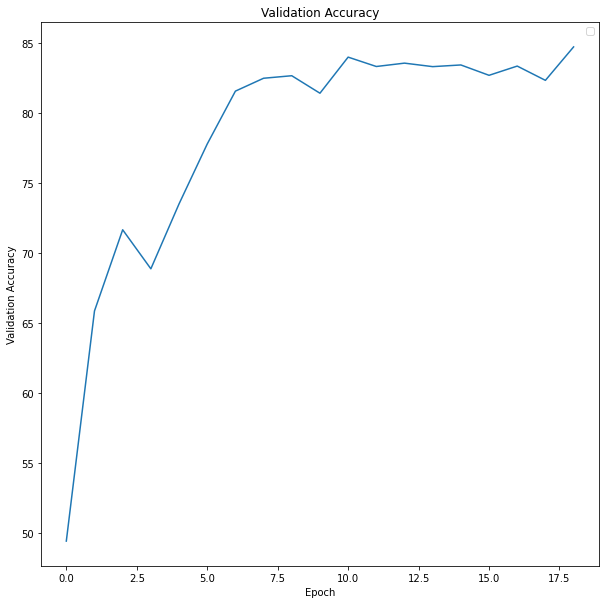

In [8]:
dm.plot_accuracy_graph()

## Plotting Loss Graph

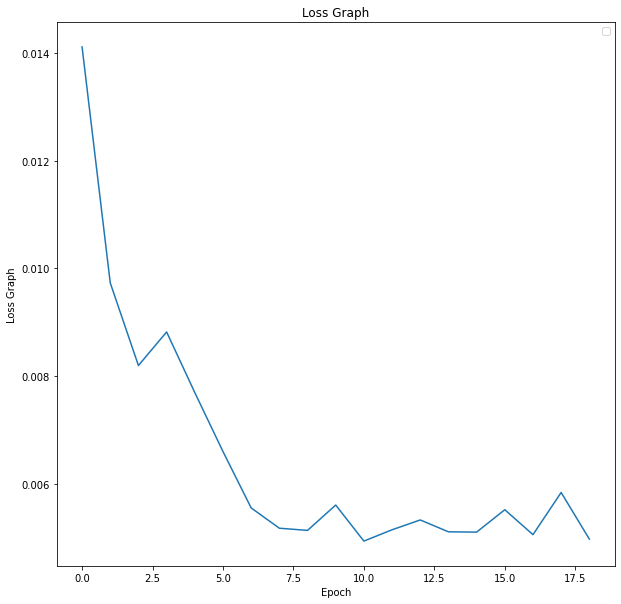

In [9]:
dm.plot_loss_graph()

## Plotting Misclassified Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

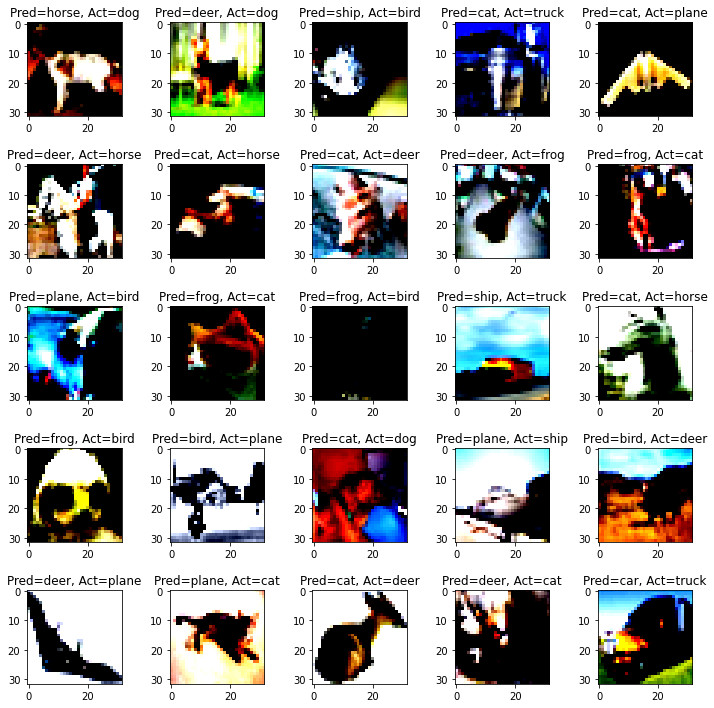

In [10]:
dm.plot_misclassified()